# MSCA 31009 MACHINE LEARNING & PREDICTIVE ANALYTICS - FINAL PROJECT

# GENERATIVE AI - DOGS IMAGE GENERATION

#### ~ a project work by GARIMA SOHI

The aim of the project is to create a GAN pipeline in order to create dog images using the dataset from Kaggle. This project is mainly divided into following three phases:

1. Data Pre-processing
2. Insights Discovery
3. Modelling

## 1. Data Pre-processing

In [1]:
# Import the necessary library for mounting Google Drive
from google.colab import drive

# Mount Google Drive to access files and directories
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import the necessary libraries
import glob
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import os
import xml.etree.ElementTree as ET
from tqdm import tqdm


Number of image files: 20655


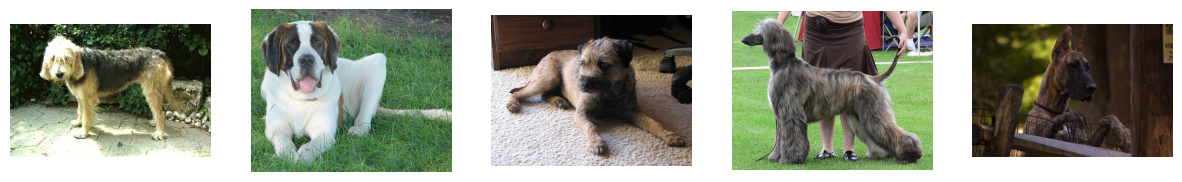

In [3]:
# Define the path to the folder containing the images on Google Drive
images_folder_path = '/content/drive/MyDrive/Colab_Notebooks/ML_FINAL_PROJECT/all-dogs'

# List all image files using glob
image_files = glob.glob(images_folder_path + '/*.jpg') + glob.glob(images_folder_path + '/*.png')

# Print the number of image files found
print(f"Number of image files: {len(image_files)}")

# Select 5 random image files
random_image_files = random.sample(image_files, 5)

# Plot the random images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Iterate over the random image files and plot them
for i, image_file in enumerate(random_image_files):
    # Open the image file using PIL (Python Imaging Library)
    image = Image.open(image_file)
    
    # Display the image on the corresponding subplot
    axes[i].imshow(image)
    
    # Turn off the axis labels
    axes[i].axis('off')

# Show the plot with the random images
plt.show()


In [4]:
def process_images(image_folder, annotation_path):
    # Initialize variables to store image information
    idxIn = 0
    namesIn = []
    imagesIn = []

    # Get a list of breed directories from the annotation path
    breeds = os.listdir(annotation_path)
    
    # Iterate over each breed and dog in the annotation path
    for breed in tqdm(breeds, desc='Processing Images'):
        for dog in os.listdir(os.path.join(annotation_path, breed)):
            try:
                # Open the image file using PIL
                img = Image.open(os.path.join(image_folder, dog + '.jpg'))
            except:
                # Skip to the next iteration if the image file cannot be opened
                continue

            # Parse the XML annotation file for the current dog
            tree = ET.parse(os.path.join(annotation_path, breed, dog))
            root = tree.getroot()
            objects = root.findall('object')

            # Iterate over each object (bounding box) in the XML annotation
            for o in objects:
                bndbox = o.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)

                # Calculate the width and height of the bounding box
                w = np.min((xmax - xmin, ymax - ymin))

                # Calculate the center coordinates of the bounding box
                center_x = (xmin + xmax) // 2
                center_y = (ymin + ymax) // 2

                # Calculate the coordinates for cropping the image with padding
                x1 = max(0, center_x - w // 2 - 40)
                y1 = max(0, center_y - w // 2 - 40)
                x2 = min(img.width, center_x + w // 2 + 40)
                y2 = min(img.height, center_y + w // 2 + 40)

                # Crop the image based on the calculated coordinates
                img2 = img.crop((x1, y1, x2, y2))
                img2 = img2.resize((80, 80))  # Resize the cropped image to 80x80

                # Convert the cropped image to a numpy array and add it to the list of images
                imagesIn.append(np.asarray(img2))

                # Add the breed name to the list of names
                namesIn.append(breed)

                # Increment the index
                idxIn += 1

    # Create a DataFrame to store the processed images and their corresponding names
    df = pd.DataFrame({'ImageIn': imagesIn, 'NamesIn': namesIn})
    return df


In [5]:
# Set the path to the folder containing the dog images on Google Drive
images_folder_path = '/content/drive/MyDrive/Colab_Notebooks/ML_FINAL_PROJECT/all-dogs'

# Set the path to the folder containing the annotation files on Google Drive
annotation_folder_path = '/content/drive/MyDrive/Colab_Notebooks/ML_FINAL_PROJECT/Annotation'

# Call the process_images() function to process the images and annotations
dogs_df = process_images(images_folder_path, annotation_folder_path)

# Display the first few rows of the DataFrame
dogs_df.head()


Processing Images: 100%|██████████| 120/120 [03:36<00:00,  1.80s/it]


,ImageIn,NamesIn
0,"[[[180, 144, 104], [180, 146, 106], [174, 140,...",n02116738-African_hunting_dog
1,"[[[216, 202, 180], [211, 199, 177], [200, 188,...",n02116738-African_hunting_dog
2,"[[[168, 155, 136], [154, 141, 122], [148, 135,...",n02116738-African_hunting_dog
3,"[[[115, 133, 78], [92, 138, 71], [87, 133, 69]...",n02116738-African_hunting_dog
4,"[[[230, 235, 231], [202, 211, 204], [226, 230,...",n02116738-African_hunting_dog


In [6]:
# Check the shape of dataframe
dogs_df.shape

(22109, 2)

In [7]:
# Check for any missing values
dogs_df.isna().sum()

ImageIn    0
NamesIn    0
dtype: int64

In [8]:
# Normalise labels of breeds in NamesIn column
dogs_df['NamesIn'] = dogs_df['NamesIn'].apply(lambda name: name.split('-')[1].lower())


In [9]:
# Confirm the changes made
dogs_df.head()

,ImageIn,NamesIn
0,"[[[180, 144, 104], [180, 146, 106], [174, 140,...",african_hunting_dog
1,"[[[216, 202, 180], [211, 199, 177], [200, 188,...",african_hunting_dog
2,"[[[168, 155, 136], [154, 141, 122], [148, 135,...",african_hunting_dog
3,"[[[115, 133, 78], [92, 138, 71], [87, 133, 69]...",african_hunting_dog
4,"[[[230, 235, 231], [202, 211, 204], [226, 230,...",african_hunting_dog


-----SAMPLE PROCESSED IMAGES AFTER CROPPING AND SCALING-----


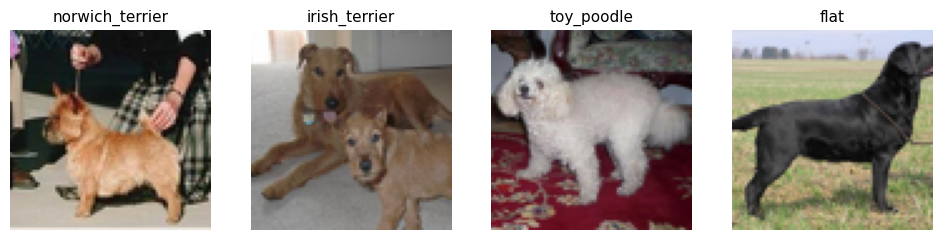

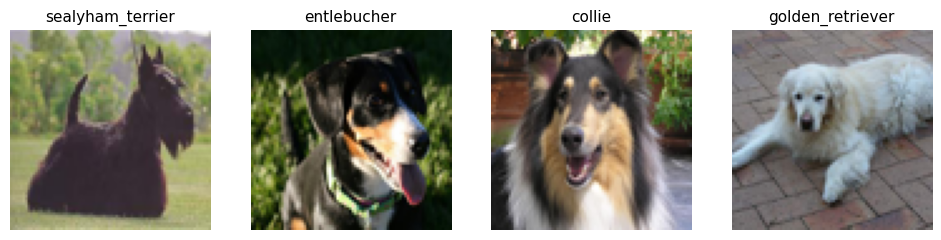

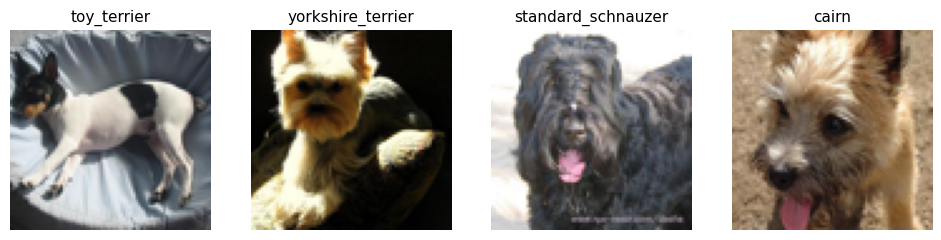

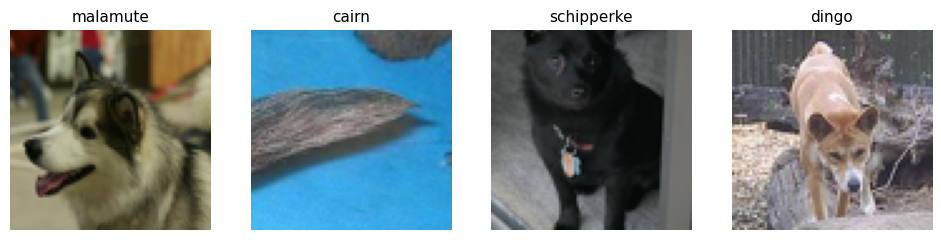

In [10]:
print('-----SAMPLE PROCESSED IMAGES AFTER CROPPING AND SCALING-----')

# Select random indices for the cropped images
x = np.random.randint(0, dogs_df.shape[0], min(20, dogs_df.shape[0]))

# Display the cropped images in a grid
for k in range(4):
    # Create a new figure with a size of 15x3 inches
    plt.figure(figsize=(15, 3))
    
    for j in range(4):
        # Define the current subplot within the figure
        plt.subplot(1, 5, j + 1)
        
        # Convert the image array to a PIL Image object
        img = Image.fromarray(dogs_df['ImageIn'].iloc[x[k * 5 + j]].astype('uint8'))
        
        # Turn off the axis labels for the current subplot
        plt.axis('off')
        
        # Set the title of the current subplot to the corresponding breed name
        plt.title(dogs_df['NamesIn'].iloc[x[k * 5 + j]], fontsize=11)
        
        # Display the image on the current subplot
        plt.imshow(img)
    
    # Show the figure with the current set of cropped images
    plt.show()


In [11]:
# Save the file
dogs_df.to_csv('/content/drive/MyDrive/Colab_Notebooks/ML_FINAL_PROJECT/dogs_data.csv', index=False)